In [ ]:
import os
import pandas as pd

def concat_csv_files(directory):
    # List to store individual DataFrames
    all_dataframes = []
    
    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory, filename)
            # Read the CSV file and append to the list
            df = pd.read_csv(file_path)
            all_dataframes.append(df)
    
    # Concatenate all DataFrames in the list
    if all_dataframes:
        combined_df = pd.concat(all_dataframes, ignore_index=True)
        
        # Write the combined DataFrame to a new CSV file
        output_path = os.path.join(directory, "combined_output.csv")
        combined_df.to_csv(output_path, index=False)
        print(f"Combined CSV saved to: {output_path}")
    else:
        print("No CSV files found in the directory.")

# Example usage
directory_path = "/projects/genomic-ml/da2343/ml_project_2/unsupervised/kmeans/strategy_figures"
concat_csv_files(directory_path)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler

# Load the data
df = pd.read_csv('combined_output.csv')

# Invert strategies with negative portfolios
def invert_negative_strategies(df):
    strategy_returns = df.groupby('instrument')['test_total_actual_return'].sum()
    negative_strategies = strategy_returns[strategy_returns < 0].index
    df.loc[df['instrument'].isin(negative_strategies), 'test_total_actual_return'] *= -1
    print("Inverted strategies:", list(negative_strategies))
    return df

# Apply the inversion
df = invert_negative_strategies(df)
df

Number of windows per strategy after preprocessing:
instrument
AUD_CAD_M15    248
AUD_JPY_M15    248
EUR_GBP_M15    248
EUR_JPY_M15    248
EUR_USD_M15    248
GBP_CHF_M15    248
GBP_JPY_M15    248
GBP_USD_M15    248
USD_CAD_M15    248
USD_CHF_M15    248
USD_JPY_M15    248
Name: window, dtype: int64
Inverted strategies: ['EUR_USD_M15', 'GBP_CHF_M15', 'GBP_JPY_M15', 'USD_CAD_M15', 'USD_CHF_M15']


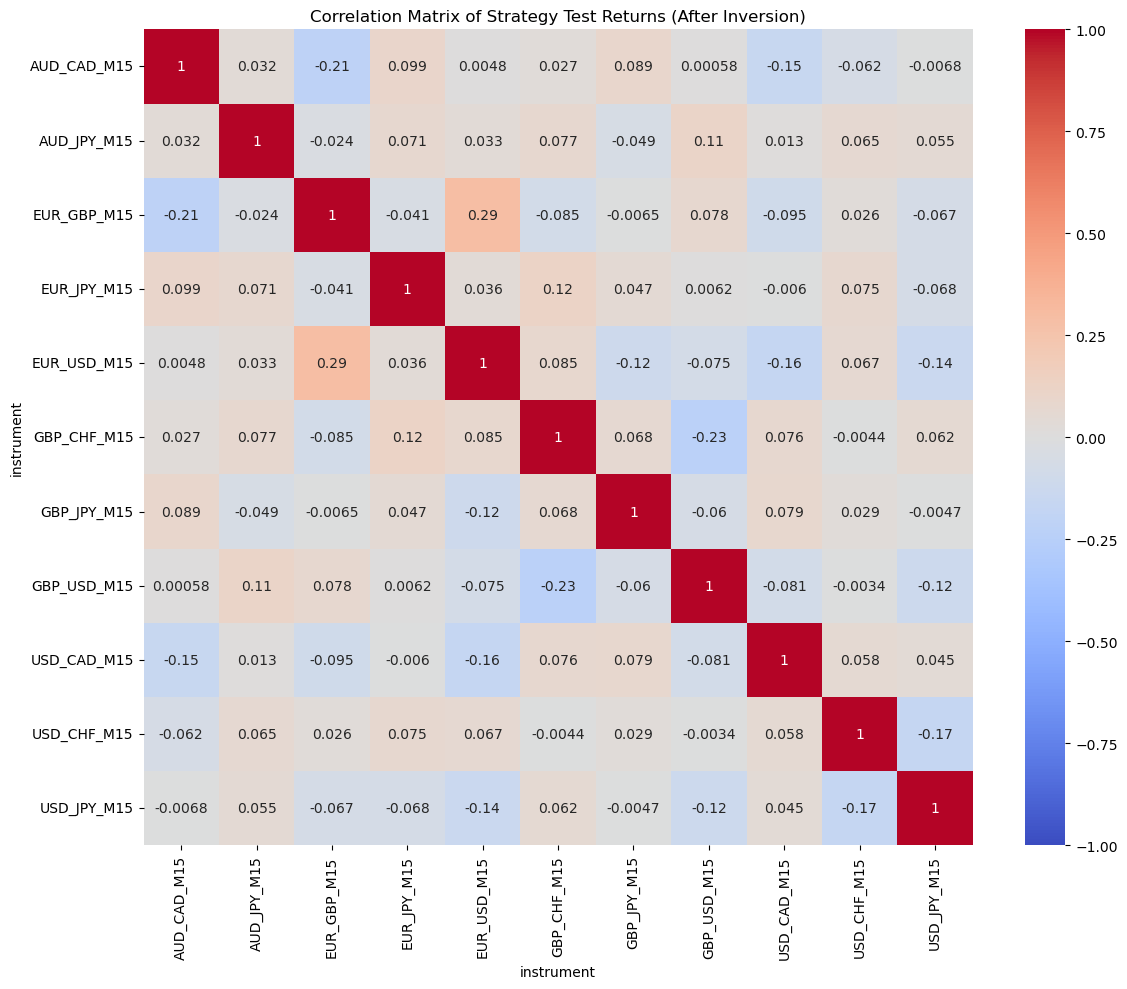

Uncorrelated Strategy Pairs:
AUD_CAD_M15 and AUD_JPY_M15
AUD_CAD_M15 and EUR_JPY_M15
AUD_CAD_M15 and EUR_USD_M15
AUD_CAD_M15 and GBP_CHF_M15
AUD_CAD_M15 and GBP_JPY_M15
AUD_CAD_M15 and GBP_USD_M15
AUD_CAD_M15 and USD_CAD_M15
AUD_CAD_M15 and USD_CHF_M15
AUD_CAD_M15 and USD_JPY_M15
AUD_JPY_M15 and EUR_GBP_M15


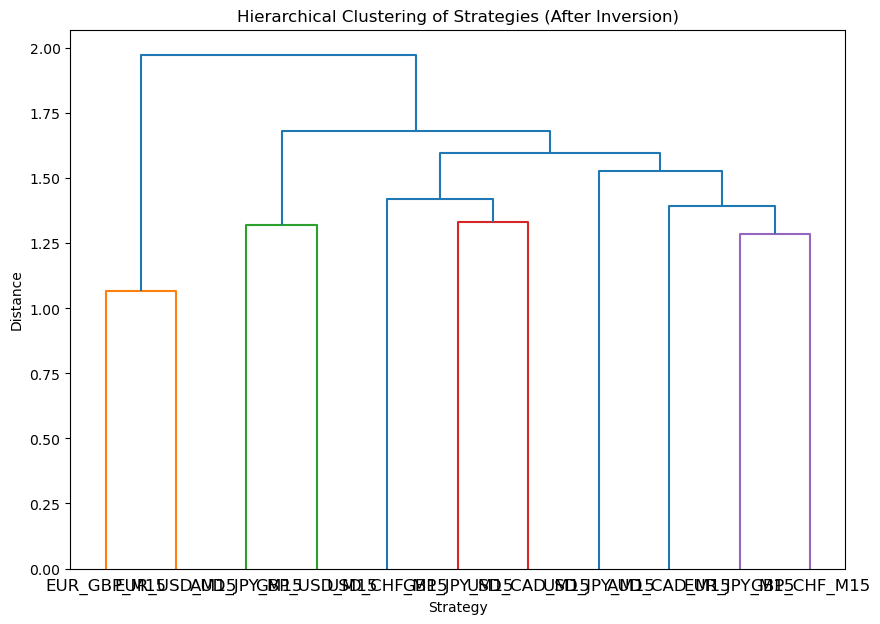


Performance Metrics (After Inversion):
             Total Return  Average Return  Standard Deviation  Sharpe Ratio
instrument                                                                 
GBP_JPY_M15         734.0        2.959677            9.213086      0.321247
GBP_CHF_M15         564.0        2.274194            7.367000      0.308700
GBP_USD_M15         464.0        1.870968            7.058997      0.265047
USD_JPY_M15         796.0        3.209677           12.397776      0.258891
AUD_JPY_M15         776.0        3.129032           12.467264      0.250980
EUR_GBP_M15         592.0        2.387097           10.205746      0.233897
EUR_USD_M15         382.0        1.540323            7.027303      0.219191
AUD_CAD_M15         668.0        2.693548           13.082224      0.205894
EUR_JPY_M15         432.0        1.741935            9.015390      0.193218
USD_CAD_M15         500.0        2.016129           11.673690      0.172707
USD_CHF_M15         513.0        2.068548       

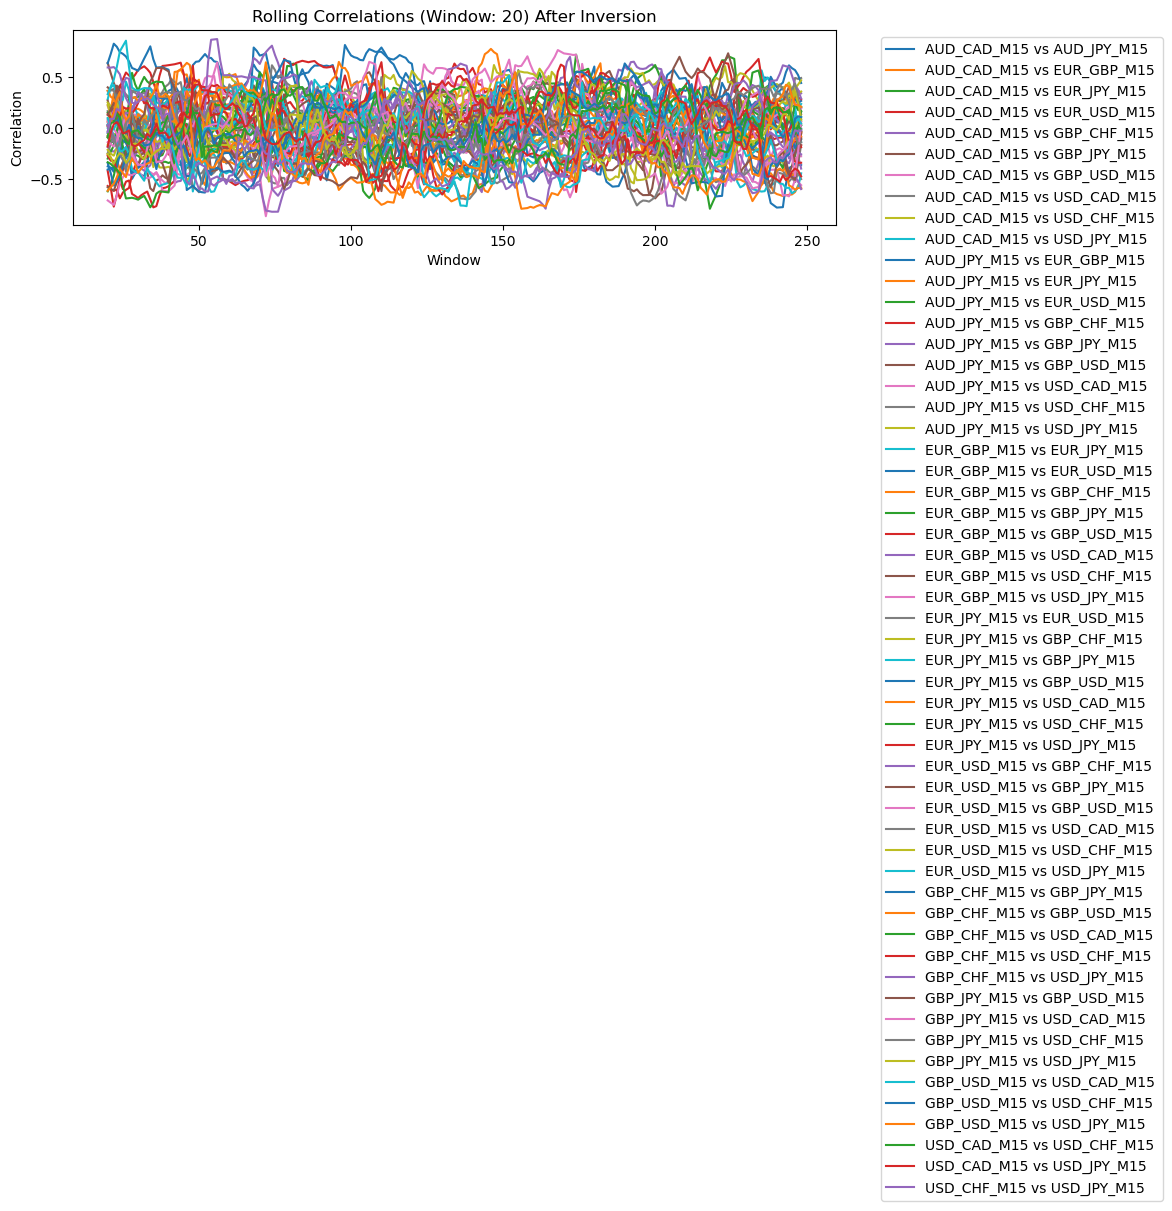

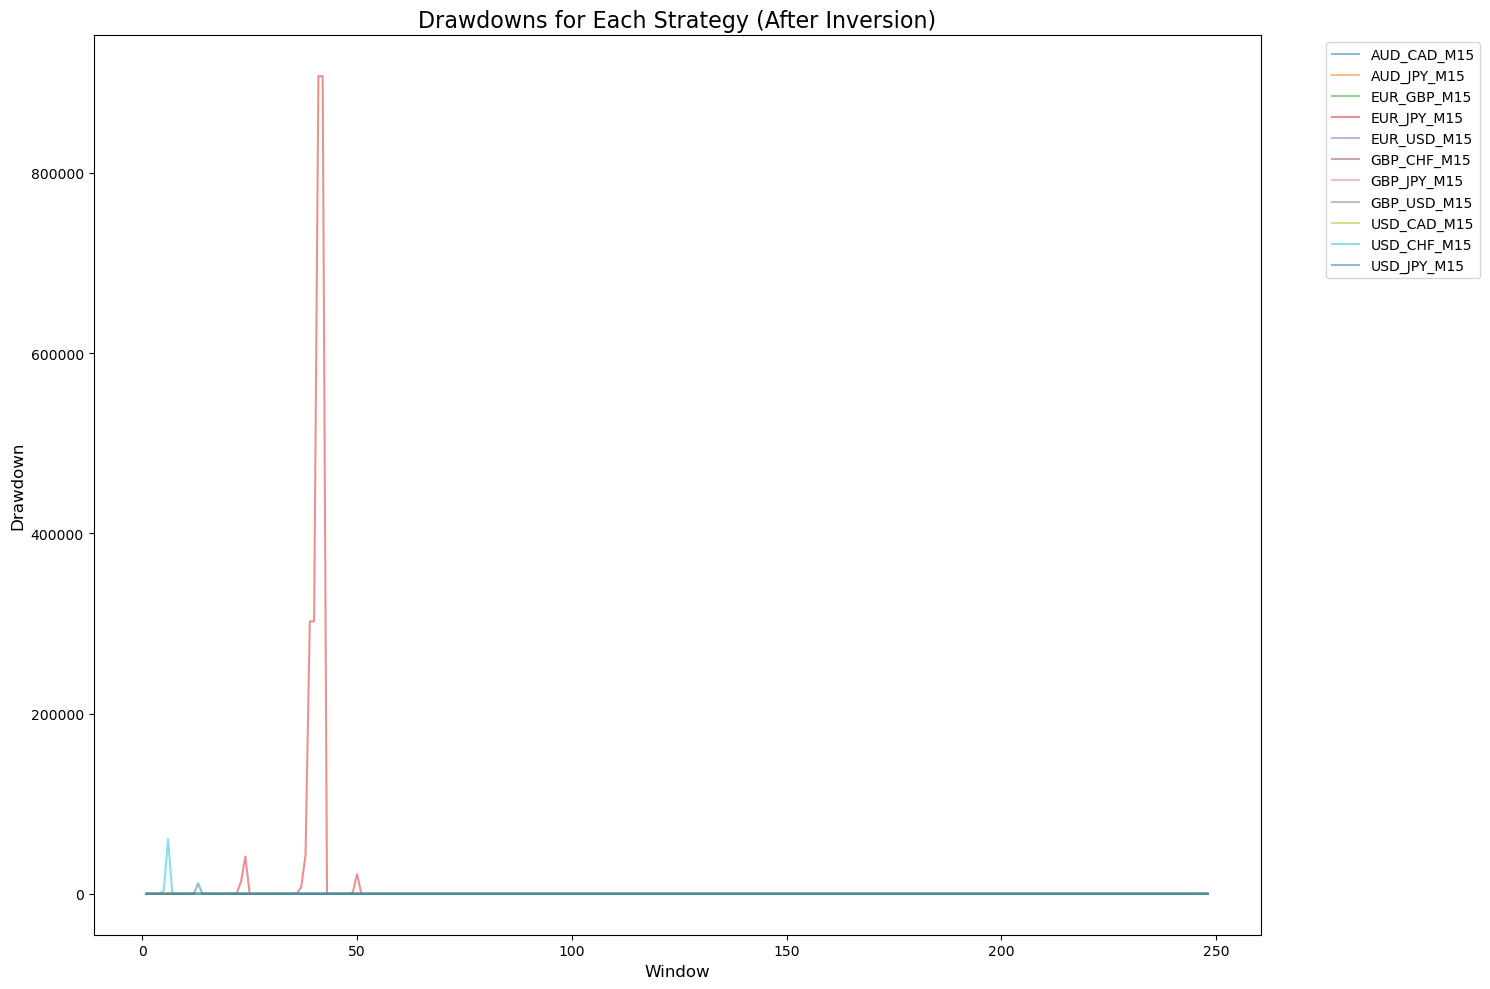


Top 10 Strategies with Lowest Maximum Drawdown:
instrument
GBP_CHF_M15        1.0
USD_CAD_M15        4.0
AUD_CAD_M15        7.0
EUR_GBP_M15        9.0
GBP_USD_M15       11.0
AUD_JPY_M15       12.0
EUR_USD_M15       14.0
GBP_JPY_M15       19.0
USD_JPY_M15    11521.0
USD_CHF_M15    60691.0
dtype: float64

Win Rate of Combined Strategy: 75.81%


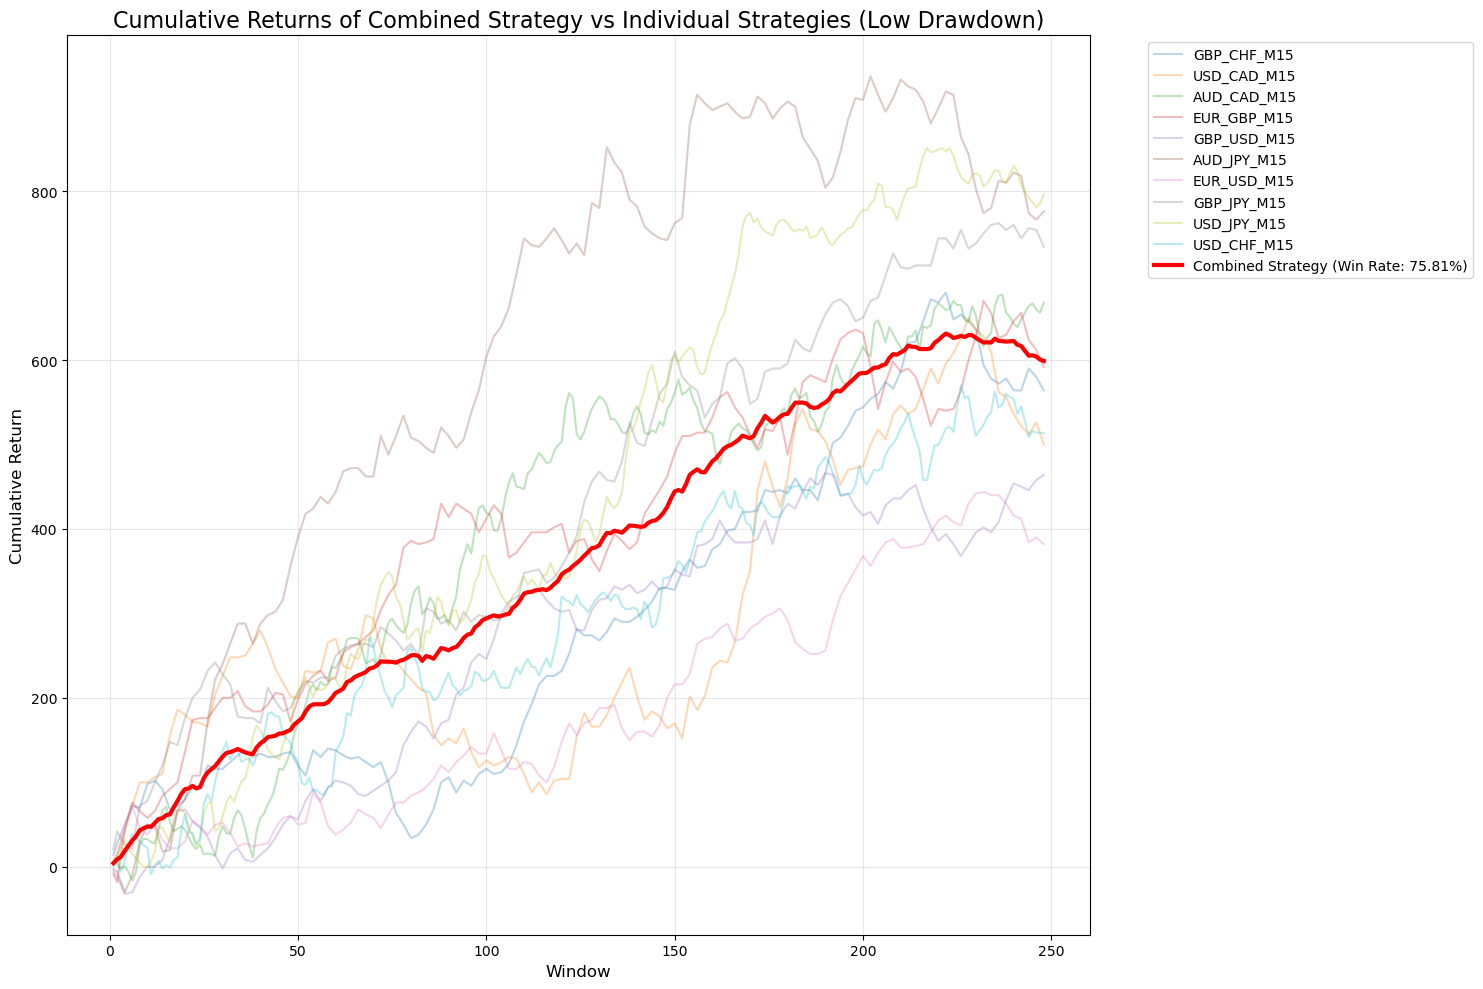


Win Rate Analysis:
Combined Strategy Win Rate: 75.81%
GBP_CHF_M15 Win Rate: 59.68%
USD_CAD_M15 Win Rate: 51.61%
AUD_CAD_M15 Win Rate: 54.84%
EUR_GBP_M15 Win Rate: 61.29%
GBP_USD_M15 Win Rate: 59.68%
AUD_JPY_M15 Win Rate: 52.42%
EUR_USD_M15 Win Rate: 58.06%
GBP_JPY_M15 Win Rate: 57.26%
USD_JPY_M15 Win Rate: 58.47%
USD_CHF_M15 Win Rate: 52.42%


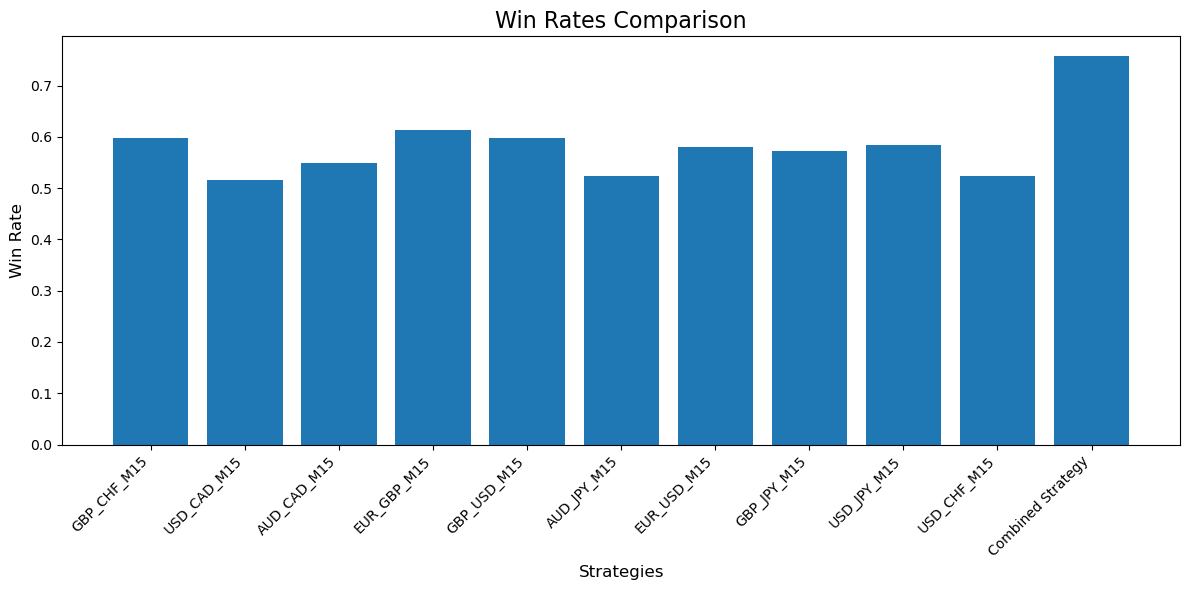

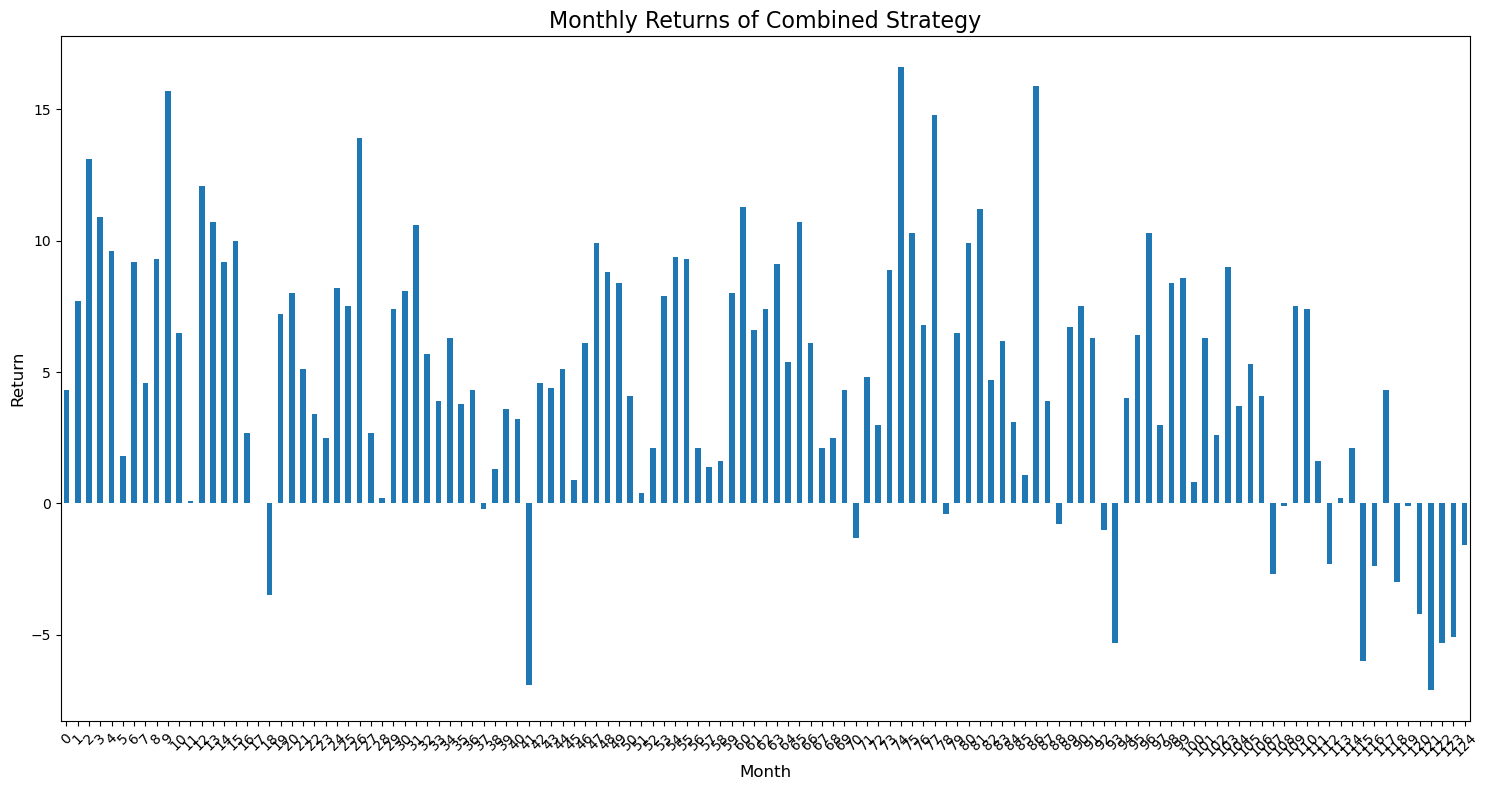


Positive Months: 104 out of 125 (83.20%)
Average Monthly Return: 479.12%
Monthly Return Standard Deviation: 493.02%

Analysis complete. Please check the generated plots for visual insights.


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler

# Load and preprocess data
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df['window'] = df['window'].astype(int)
    
    min_windows = df.groupby('instrument')['window'].nunique().min()
    
    def get_last_n_windows(group, n):
        return group.sort_values('window').tail(n)
    
    filtered_df = df.groupby('instrument').apply(lambda x: get_last_n_windows(x, min_windows)).reset_index(drop=True)
    filtered_df['window'] = filtered_df.groupby('instrument').cumcount() + 1
    filtered_df = filtered_df.sort_values(['instrument', 'window']).reset_index(drop=True)
    
    print("Number of windows per strategy after preprocessing:")
    print(filtered_df.groupby('instrument')['window'].nunique())
    
    return filtered_df

# Invert strategies with negative portfolios
def invert_negative_strategies(df):
    strategy_returns = df.groupby('instrument')['test_total_actual_return'].sum()
    negative_strategies = strategy_returns[strategy_returns < 0].index
    df.loc[df['instrument'].isin(negative_strategies), 'test_total_actual_return'] *= -1
    print("Inverted strategies:", list(negative_strategies))
    return df

# Correlation Matrix and Heatmap
def plot_correlation_matrix(df):
    pivot_df = df.pivot(index='window', columns='instrument', values='test_total_actual_return')
    corr_matrix = pivot_df.corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Matrix of Strategy Test Returns (After Inversion)')
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

# Uncorrelated Strategy Pairs
def find_uncorrelated_pairs(corr_matrix, threshold=0.2):
    uncorrelated_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) < threshold:
                uncorrelated_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))
    return uncorrelated_pairs

# Hierarchical Clustering
def plot_dendrogram(corr_matrix):
    dist_matrix = 1 - corr_matrix
    condensed_dist = pdist(dist_matrix)
    linkage_matrix = linkage(condensed_dist, method='ward')
    
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix, labels=corr_matrix.columns)
    plt.title('Hierarchical Clustering of Strategies (After Inversion)')
    plt.xlabel('Strategy')
    plt.ylabel('Distance')
    plt.show()

# Performance Metrics
def calculate_performance_metrics(df):
    grouped = df.groupby('instrument')
    total_returns = grouped['test_total_actual_return'].sum()
    avg_returns = grouped['test_total_actual_return'].mean()
    std_returns = grouped['test_total_actual_return'].std()
    sharpe_ratios = avg_returns / std_returns
    
    metrics = pd.DataFrame({
        'Total Return': total_returns,
        'Average Return': avg_returns,
        'Standard Deviation': std_returns,
        'Sharpe Ratio': sharpe_ratios
    })
    
    return metrics.sort_values('Sharpe Ratio', ascending=False)

# Time-varying Correlations
def plot_rolling_correlations(df, window=20):
    pivot_df = df.pivot(index='window', columns='instrument', values='test_total_actual_return')
    rolling_corr = pivot_df.rolling(window=window).corr()
    
    plt.figure(figsize=(12, 8))
    for i in range(len(pivot_df.columns)):
        for j in range(i+1, len(pivot_df.columns)):
            plt.plot(rolling_corr.index.levels[0], rolling_corr.loc[(slice(None), pivot_df.columns[i]), pivot_df.columns[j]], 
                     label=f'{pivot_df.columns[i]} vs {pivot_df.columns[j]}')
    
    plt.title(f'Rolling Correlations (Window: {window}) After Inversion')
    plt.xlabel('Window')
    plt.ylabel('Correlation')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Drawdown Analysis
def calculate_drawdowns(df):
    pivot_df = df.pivot(index='window', columns='instrument', values='test_total_actual_return')
    cumulative_returns = (1 + pivot_df).cumprod()
    peak = cumulative_returns.cummax()
    drawdowns = (peak - cumulative_returns) / peak
    return drawdowns.fillna(0)

def plot_drawdowns(drawdowns):
    plt.figure(figsize=(15, 10))
    for column in drawdowns.columns:
        plt.plot(drawdowns.index, drawdowns[column], label=column, alpha=0.5)
    plt.title('Drawdowns for Each Strategy (After Inversion)', fontsize=16)
    plt.xlabel('Window', fontsize=12)
    plt.ylabel('Drawdown', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.show()

# Strategy Combination
def combine_strategies(df, strategies):
    strategy_df = df[df['instrument'].isin(strategies)]
    combined_returns = strategy_df.groupby('window')['test_total_actual_return'].mean()
    
    win_rate = (combined_returns > 0).mean()
    print(f"\nWin Rate of Combined Strategy: {win_rate:.2%}")
    
    return combined_returns, win_rate

# New function to visualize monthly returns
def plot_monthly_returns(combined_returns):
    # Assuming two windows is a month
    monthly_returns = combined_returns.groupby(combined_returns.index // 2).sum()
    
    plt.figure(figsize=(15, 8))
    monthly_returns.plot(kind='bar')
    plt.title('Monthly Returns of Combined Strategy', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Return', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Calculate and print additional statistics
    positive_months = (monthly_returns > 0).sum()
    total_months = len(monthly_returns)
    print(f"\nPositive Months: {positive_months} out of {total_months} ({positive_months/total_months:.2%})")
    print(f"Average Monthly Return: {monthly_returns.mean():.2%}")
    print(f"Monthly Return Standard Deviation: {monthly_returns.std():.2%}")

# Main execution
if __name__ == "__main__":
    df = load_and_preprocess_data('combined_output.csv')
    df = invert_negative_strategies(df)
    
    corr_matrix = plot_correlation_matrix(df)
    
    uncorrelated_pairs = find_uncorrelated_pairs(corr_matrix)
    print("Uncorrelated Strategy Pairs:")
    for pair in uncorrelated_pairs[:10]:
        print(f"{pair[0]} and {pair[1]}")
    
    plot_dendrogram(corr_matrix)
    
    performance_metrics = calculate_performance_metrics(df)
    print("\nPerformance Metrics (After Inversion):")
    print(performance_metrics)
    
    plot_rolling_correlations(df)
    
    drawdowns = calculate_drawdowns(df)
    plot_drawdowns(drawdowns)
    
    max_drawdowns = drawdowns.max()
    top_10_low_drawdown = max_drawdowns.nsmallest(10)
    
    print("\nTop 10 Strategies with Lowest Maximum Drawdown:")
    print(top_10_low_drawdown)
    
    low_drawdown_strategies = top_10_low_drawdown.index.tolist()
    combined_returns, win_rate = combine_strategies(df, low_drawdown_strategies)
    
    plt.figure(figsize=(15, 10))
    
    for strategy in low_drawdown_strategies:
        strategy_returns = df[df['instrument'] == strategy].set_index('window')['test_total_actual_return']
        plt.plot(strategy_returns.index, strategy_returns.cumsum(), label=strategy, alpha=0.3)
    
    plt.plot(combined_returns.index, combined_returns.cumsum(), label=f'Combined Strategy (Win Rate: {win_rate:.2%})', 
             color='red', linewidth=3, alpha=1)
    
    plt.title('Cumulative Returns of Combined Strategy vs Individual Strategies (Low Drawdown)', fontsize=16)
    plt.xlabel('Window', fontsize=12)
    plt.ylabel('Cumulative Return', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\nWin Rate Analysis:")
    print(f"Combined Strategy Win Rate: {win_rate:.2%}")
    
    individual_win_rates = {}
    for strategy in low_drawdown_strategies:
        strategy_returns = df[df['instrument'] == strategy]['test_total_actual_return']
        strategy_win_rate = (strategy_returns > 0).mean()
        individual_win_rates[strategy] = strategy_win_rate
        print(f"{strategy} Win Rate: {strategy_win_rate:.2%}")
    
    plt.figure(figsize=(12, 6))
    strategies = list(individual_win_rates.keys()) + ['Combined Strategy']
    win_rates = list(individual_win_rates.values()) + [win_rate]
    plt.bar(strategies, win_rates)
    plt.title('Win Rates Comparison', fontsize=16)
    plt.xlabel('Strategies', fontsize=12)
    plt.ylabel('Win Rate', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # New: Visualize monthly returns
    plot_monthly_returns(combined_returns)

    print("\nAnalysis complete. Please check the generated plots for visual insights.")

In [27]:
df

,window,train_total_annualized_return,train_total_actual_return,train_total_trades,test_total_annualized_return,test_total_actual_return,test_total_trades,train_cumulative_actual_return,train_sharpe_ratio,test_cumulative_actual_return,test_sharpe_ratio,test_inverse_sharpe_ratio,max_cluster_labels,num_clusters,clustering_algorithm,train_period,test_period,random_seed,instrument
0,1,0.50,50.0,108,0.05,5.0,15,1188.0,3.189539,49.0,0.126288,-0.279659,1,80,gaussian_mixture,8,2,42,AUD_CAD_M15
1,2,0.64,64.0,72,-0.02,-2.0,20,1252.0,3.189539,47.0,0.126288,-0.279659,1,80,gaussian_mixture,8,2,42,AUD_CAD_M15
2,3,0.76,76.0,100,-0.05,-5.0,31,1328.0,3.189539,42.0,0.126288,-0.279659,1,80,gaussian_mixture,8,2,42,AUD_CAD_M15
3,4,0.55,55.0,105,0.03,3.0,7,1383.0,3.189539,45.0,0.126288,-0.279659,1,80,gaussian_mixture,8,2,42,AUD_CAD_M15
4,5,0.39,39.0,90,-0.07,-7.0,21,1422.0,3.189539,38.0,0.126288,-0.279659,1,80,gaussian_mixture,8,2,42,AUD_CAD_M15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2723,244,0.46,46.0,92,-0.07,-7.0,9,14965.0,2.635804,767.0,0.152627,-0.312492,1,70,gaussian_mixture,12,2,200,USD_JPY_M15
2724,245,0.42,42.0,93,-0.05,-5.0,5,15007.0,2.635804,762.0,0.152627,-0.312492,1,70,gaussian_mixture,12,2,200,USD_JPY_M15
2725,246,0.27,27.0,60,-0.06,-6.0,6,15034.0,2.635804,756.0,0.152627,-0.312492,1,70,gaussian_mixture,12,2,200,USD_JPY_M15
2726,247,0.23,23.0,84,0.05,5.0,13,15057.0,2.635804,761.0,0.152627,-0.312492,1,70,gaussian_mixture,12,2,200,USD_JPY_M15
